# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [149]:
import json

In [2]:
import networkx as nx

# Data

In [3]:
project_path = "./drive/MyDrive/Colab_Notebooks/Projects/Crypto"

In [4]:
data = pd.read_csv(project_path + "/Data/" + "tweet_df.csv",index_col=0,parse_dates=['created_at','retweeted_status-user-created_at','retweeted_status-user-created_at'])

In [5]:
data.head() 

,created_at,id,text,in_reply_to_screen_name,place,quote_count,reply_count,retweet_count,favorite_count,entities,user-screen_name,user-created_at,user-followers_count,user-location,retweeted_status-user-screen_name,retweeted_status-user-created_at,retweeted_status-user-followers_count,retweeted_status-text,quoted_status-user-created_at,quoted_status-user-followers_count,quoted_status-text
0,2021-11-08 16:10:21+00:00,1.457742e+18,RT @ArkerCommunity: Discover the new metaverse...,NaN,NaN,0.0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",Faiz_2294,2021-05-12 08:32:39+00:00,32.0,"Magelang Utara, Indonesia",ArkerCommunity,2017-10-16 10:31:14+00:00,26263.0,"Discover the new metaverse of Arker, start a n...",NaN,NaN,NaN
1,2021-11-08 16:10:21+00:00,1.457742e+18,RT @FEhrsam: Have invested in a few groups wor...,NaN,NaN,0.0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",SpaceXEng,2012-08-16 00:05:01+00:00,2266.0,420.69,FEhrsam,2011-06-12 19:33:04+00:00,170231.0,Have invested in a few groups working on new c...,2011-05-08 16:03:03+00:00,2709261.0,Crypto cities!\n\nhttps://t.co/mUdpYJSDq0
2,2021-11-08 16:10:21+00:00,1.457742e+18,RT @djs_crypto: Crowdsale Contract is the core...,NaN,NaN,0.0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",Embr_Dil,2021-07-26 19:28:15+00:00,66.0,NaN,djs_crypto,2021-04-23 10:39:56+00:00,131.0,Crowdsale Contract is the core of the Embr IDO...,NaN,NaN,NaN
3,2021-11-08 16:10:21+00:00,1.457742e+18,RT @backerfigth: The #SmartDeFi #launchpad wit...,NaN,NaN,0.0,0,0,0,"{'hashtags': [{'text': 'SmartDeFi', 'indices':...",yasinsoyudemir1,2019-05-16 15:19:16+00:00,144.0,NaN,backerfigth,2021-02-02 18:21:04+00:00,437.0,The #SmartDeFi #launchpad with its integration...,NaN,NaN,NaN
4,2021-11-08 16:10:21+00:00,1.457742e+18,RT @cryptoman71: @bezoge AMA live now!!\n\nhtt...,NaN,NaN,0.0,0,0,0,"{'hashtags': [{'text': 'Crypto', 'indices': [6...",CryptoEarner968,2021-02-20 16:45:54+00:00,3224.0,"Paris, France",cryptoman71,2021-05-17 10:04:43+00:00,228.0,@bezoge AMA live now!!\n\nhttps://t.co/EXZofTr...,NaN,NaN,NaN


In [6]:
data = data[data.index.to_series().apply(lambda x: True if x.isdigit() else False)] #Some unidentifiable data corruption during writing to/ reading from disk

# Most Talked About Coins

In [93]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False)
    return contains_column

In [94]:
coins_to_monitor = ['bitcoin', 'ethereum', 'solana', 'cardano', 'ripple', 'polkadot', 'dogecoin', 'avalanche', 'litecoin']

In [95]:
# Make a DataFrame of Logical Series 
coins_dict = {}

for coin in coins_to_monitor:
  coins_dict[coin] = check_word_in_tweet(coin,data)

coins_df = pd.DataFrame(coins_dict,index = data.index,columns = coins_to_monitor)

In [96]:
coins_df.head()

,bitcoin,ethereum,solana,cardano,ripple,polkadot,dogecoin,avalanche,litecoin
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False


In [97]:
coins_df.shape

(50000, 9)

In [98]:
for col in coins_df:
  print(f"Proportion of tweets discussing {col}:", sum(coins_df[col]) / len(coins_df[col]))

Proportion of tweets discussing bitcoin: 0.11968
Proportion of tweets discussing ethereum: 0.03718
Proportion of tweets discussing solana: 0.02922
Proportion of tweets discussing cardano: 0.01364
Proportion of tweets discussing ripple: 0.00458
Proportion of tweets discussing polkadot: 0.0048
Proportion of tweets discussing dogecoin: 0.0163
Proportion of tweets discussing avalanche: 0.00344
Proportion of tweets discussing litecoin: 0.00274


# Mentions Over Time

In [37]:
temp = coins_df.copy()
temp.index = data.created_at

In [38]:
coins_df_resampled = temp.resample('1min').sum()

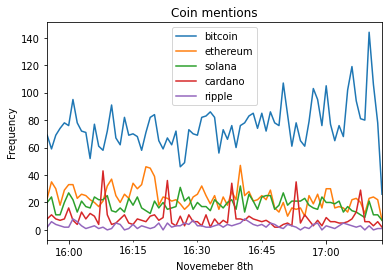

In [45]:
coins_df_resampled.iloc[:,:5].plot()

# Add labels and show
plt.xlabel('Novemeber 8th'); plt.ylabel('Frequency')
plt.title('Coin mentions');

Observe how the cardano coin is spiking every 15 minutes. 

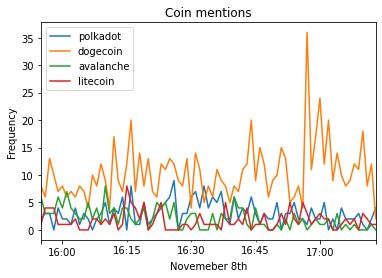

In [46]:
coins_df_resampled.iloc[:,5:].plot()

plt.xlabel('Novemeber 8th'); plt.ylabel('Frequency')
plt.title('Coin mentions');

# Sentiment Surrounding the Coins

In [48]:
#The sentiment prediction model
sid = SentimentIntensityAnalyzer()

In [79]:
sentiment_scores = data['text'].apply(sid.polarity_scores)

In [81]:
sentiment_scores.head()

0    {'neg': 0.112, 'neu': 0.644, 'pos': 0.244, 'co...
1    {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...
2    {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...
3    {'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: text, dtype: object

In [82]:
sentiment = sentiment_scores.apply(lambda x: x['compound'])

Note: This model does not perform that well because of the unique langauge involved with twitter and, more specifically, by peoople discussing crypto 

In [84]:
# Print out the text of a positive tweet
print(data[sentiment > 0.6]['text'].values[0])

RT @Next100XGEMS: 🔥THE MARKET ISN’T STATIC, SO  WHY SHOULD YOUR REWARDS BE? 🔥

🚀 $HEDGE THE FIRST DYNAMIC REWARD TOKEN. 

OVER 70K IN REWAR…


In [88]:
# Print out the text of a positive tweet
print(data[sentiment <- 0.6]['text'].values[0])

🙌🙌😊 let’s mAke this shit happen !!! #freedom


In [128]:
# Make a DataFrame of average sentiment score each minute for each coin throughout the hour

coins_sentiment_dict = {}

temp = coins_df.copy()
temp.index = data.created_at
temp['sentiment'] = sentiment.values

for coin in coins_to_monitor:
  coins_sentiment_dict[coin] = temp.sentiment[temp[coin]].resample('5min').mean()


In [129]:
coins_sentiment_df = pd.DataFrame(coins_sentiment_dict)

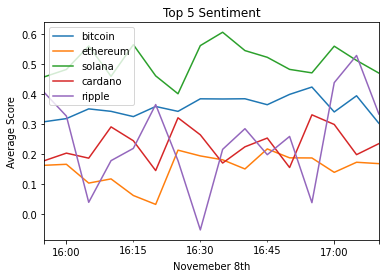

In [130]:
coins_sentiment_df.iloc[:,:5].plot()

# Add labels and show
plt.xlabel('Novemeber 8th'); plt.ylabel('Average Score')
plt.title('Top 5 Sentiment');

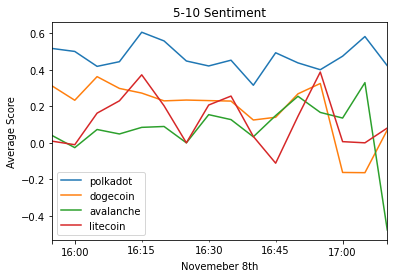

In [131]:
coins_sentiment_df.iloc[:,5:].plot()

# Add labels and show
plt.xlabel('Novemeber 8th'); plt.ylabel('Average Score')
plt.title('5-10 Sentiment');

# Geographic Info

Using Listed Location

In [132]:
data['user-location'].value_counts()

United States                   430
Indonesia                       404
USA                             245
India                           202
Lagos, Nigeria                  196
                               ... 
MY  ❤️                            1
Messier 31                        1
Paradise Island                   1
Fulham Road, London, SW6 1HS      1
sofia                             1
Name: user-location, Length: 6907, dtype: int64

Using Centriods

In [ ]:
!pip install geopandas

In [161]:
import geopandas

In [178]:
def calculateCentroid(place):
    """ Calculates the centroid from a bounding box."""

    place = eval(place) #dicts stored as strings

    # Obtain the coordinates from the bounding box.
    coordinates = place['bounding_box']['coordinates'][0]
        
    longs = np.unique( [x[0] for x in coordinates] )
    lats  = np.unique( [x[1] for x in coordinates] )


    if len(longs) == 1 and len(lats) == 1:
        # return a single coordinate
        return (longs[0], lats[0])
    elif len(longs) == 2 and len(lats) == 2:
        # If we have two longs and lats, we have a box.
        central_long = np.sum(longs) / 2
        central_lat  = np.sum(lats) / 2
    else:
        raise ValueError("Non-rectangular polygon not supported: %s" % 
            ",".join(map(lambda x: str(x), coordinates)) )

    return (central_long, central_lat)

In [179]:
centroids = data.place[data.place.notna()].apply(calculateCentroid)

In [198]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

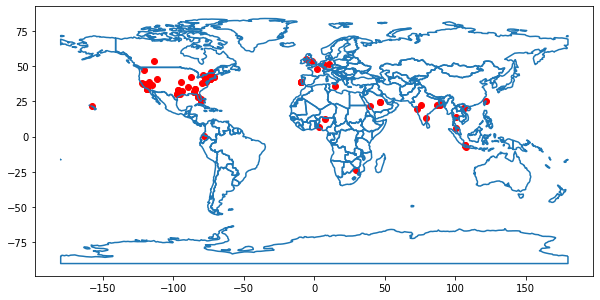

In [200]:
world = world.boundary.plot(figsize=(10,6))
x = centroids.apply(lambda x: x[0])
y = centroids.apply(lambda x: x[1])


world.scatter(x,y,color='r')

# Network Analysis (Ratio'd)

Want to see who are the central voices in this twitter network. Additionally, I will use the ratio of the reply to retweet degree centrality as a measure of disapproval of a user within the network

In [7]:
retweets = data[data['retweeted_status-text'].notna()]
replies = data[data.in_reply_to_screen_name.notna()]

In [19]:
#The Retweet Edgelist

retweets.loc[:,['user-screen_name','retweeted_status-user-screen_name']].head()

,user-screen_name,retweeted_status-user-screen_name
0,Faiz_2294,ArkerCommunity
1,SpaceXEng,FEhrsam
2,Embr_Dil,djs_crypto
3,yasinsoyudemir1,backerfigth
4,CryptoEarner968,cryptoman71


In [10]:
# Create retweet and reply networks from edgelist
G_rt = nx.from_pandas_edgelist(
    retweets,
    source = 'user-screen_name',
    target = "retweeted_status-user-screen_name",
    create_using = nx.DiGraph())

In [11]:
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edgesm
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 24379
Edges in RT network: 27594


In [12]:
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

In [14]:
# Store centralities in DataFrame
column_names = ['screen_name', 'degree_centrality']
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

In [16]:
# Print first five results in descending order of centrality
print("Top Retweet Network")
print(rt.sort_values('degree_centrality',ascending=False).head())

Top Retweet Network
       screen_name  degree_centrality
27       Bang_Garr           0.094635
15     POODLETOKEN           0.042128
68  airdropinspect           0.032242
13     WatcherGuru           0.029699
1   ArkerCommunity           0.019485


In [17]:
# Repeat for Reply network

G_reply = nx.from_pandas_edgelist(
    replies,
    source = 'user-screen_name',
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())

reply_centrality = nx.in_degree_centrality(G_reply)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

print("Top Reply Network")
print(reply.sort_values('degree_centrality', ascending = False).head())

Top Reply Network
          screen_name  degree_centrality
73        polkawarnft           0.017142
103    ArkerCommunity           0.013067
105        MechaChain           0.008993
167     CoinMarketCap           0.006604
1021  davidgokhshtein           0.006042


In [18]:
# Calculate in-degrees and store in DataFrame
degree_rt = pd.DataFrame(list(G_rt.in_degree()), columns = ['screen_name', 'degree'])
degree_reply = pd.DataFrame(list(G_reply.in_degree()), columns = ['screen_name', 'degree'])

# Merge the two DataFrames on screen name
ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))

# Calculate the ratio
ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

# Exclude any tweets with less than 5 retweets
ratio = ratio[ratio['degree_rt'] >= 5]

# Print out first five with highest ratio
print(ratio.sort_values('ratio', ascending = False).head())

         screen_name  degree_rt  degree_reply     ratio
28   davidgokhshtein         10            43  4.300000
374      TheMoonCarl         17            39  2.294118
263           crypto         13            29  2.230769
140    AltCryptoGems          5             9  1.800000
159          gate_io         19            29  1.526316
